In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Python <a class="anchor" id="3.-Python"></a>
**Задача 3.1**  
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.


Для решения использованы данные первого задания, поэтому функция будет расчитывать метрики определенные в А/Б тесте первого задания: CR, AOV, RPV

In [2]:
def add_groups(add_data): 
    '''Функция для расчета метрик'''
    url_groups = 'https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_groups.csv'
    url_active_studs = 'https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_active_studs.csv'
    url_checks = 'https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_checks.csv'
    url_groups_add = add_data
    groups = pd.read_csv(url_groups, sep=';')
    active_studs = pd.read_csv(url_active_studs)
    checks = pd.read_csv(url_checks, sep=';')
    groups_add = pd.read_csv(url_groups_add)
    # Объединим данные о группах
    combined_groups = pd.concat([groups, groups_add])
    # Добавили признак активности (1-активный, 0-неактивный)
    combined_groups['active'] = np.where(combined_groups['id'].isin(active_studs['student_id']) == True, 1, 0)
    
    # Добавили сумму оплаты
    checks = checks.rename(columns={'student_id': 'id'})
    user_data = combined_groups.merge(checks[['id', 'rev']], on='id', how='left')
    user_data['rev'] = round(user_data['rev'].fillna(0), 2)
    active_users = user_data.query('active == 1')\
    .groupby('grp', as_index=False)\
    .agg(amount_active_users=('id', 'count')) 
    check_users = user_data.query('active == 1 & rev>0')\
    .groupby('grp', as_index=False)\
    .agg(amount_check_users=('id', 'count'), rev_check=('rev', 'sum'))
         
    df = active_users.merge(check_users, on='grp', how='left')
    df['CR'] = (df['amount_check_users'] / df['amount_active_users']) * 100
    df['AOV'] = df['rev_check'] / df['amount_check_users']
    df['RPV'] = df['CR'] * df['AOV']
         
    metrics = round(df[['grp', 'CR', 'AOV', 'RPV']], 2) 
    metrics = metrics.replace({'grp': {'A': 'control', 'B': 'test'}})
  
    return metrics

In [3]:
def get_diff(metrics):
    '''Функция для расчета разниц в метриках'''
    control = metrics.iloc[0, 1:4]
    test = metrics.iloc[1, 1:4]
    diff = test - control
    diff_lst = list(diff)
    
    diff_dict = {'CR_diff': diff_lst[0], 'AOV_diff': diff_lst[1], 'RPV_diff': diff_lst[2]} 
    difference = pd.DataFrame(diff_dict, index=['test-control'])
    diff_df = difference.style.applymap(lambda v: "color:green;" if v > 0 else "color:red;")

    return diff_df

Получена ссылка на дополнительные данные https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_group_add.csv

In [4]:
url_add = input('Введите ссылку на данные ')
display(add_groups(url_add))
display(get_diff(add_groups(url_add)))

Введите ссылку на данные https://raw.githubusercontent.com/GerelMN/portfolio_projects/main/online_courses_orders_checkouts/dataset/project_2_group_add.csv


,grp,CR,AOV,RPV
0,control,5.07,933.59,4734.72
1,test,4.62,1257.88,5805.88


,CR_diff,AOV_diff,RPV_diff
test-control,-0.450000,324.290000,1071.160000


#### Задача 3.2 <a class="anchor" id="Задача-3.2"></a>

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [59]:
def graph_plot(metrics):
    '''Функция для построения графиков'''
    fig, ax = plt.subplots(1, 3, figsize=(20, 10)) 
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    cr = sns.barplot(ax=ax[0], x='grp', y='CR', data=metrics)
    cr.set_title("Conversion Rate", fontsize=14)
    cr.set_ylabel("%", fontsize=14)
    aov = sns.barplot(ax=ax[1], x='grp', y='AOV', data=metrics)
    aov.set_title("Average Order Value", fontsize=14)
    aov.set_ylabel("rub.", fontsize=14)
    rpv = sns.barplot(ax=ax[2], x='grp', y='RPV', data=metrics)
    rpv.set_title("Revenue per Visitor", fontsize=14)
    rpv.set_ylabel("rub.", fontsize=14)
    for axis in ax.ravel():
        axis.set_fontsize = 20
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        axis.set_xlabel('groups', fontsize=12)
        axis.tick_params(axis='both', which='major', labelsize=14)

    fig.suptitle('METRICS for A/B test', fontsize=20, fontweight='bold')
    return fig.show

<bound method Figure.show of <Figure size 1440x720 with 3 Axes>>

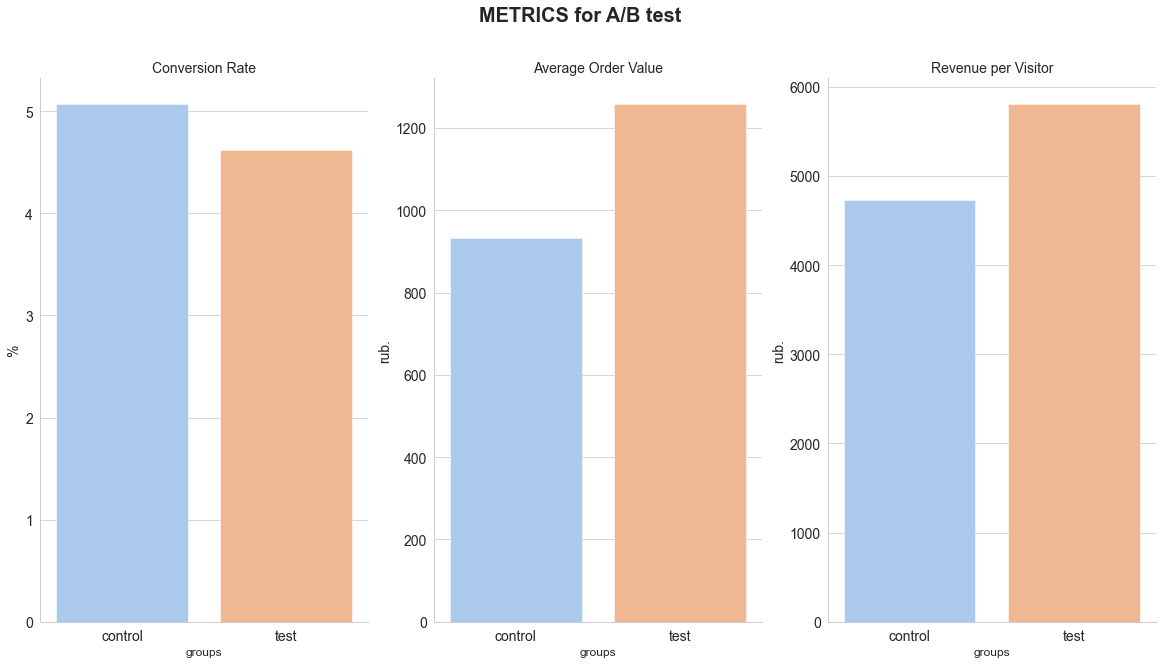

In [61]:
graph_plot(add_groups(url_add))